# Benchmarking
benchmarking using [MQTBench](https://mqt.readthedocs.io/projects/bench/en/latest/Quickstart.html) with QFT for 15 qubits

In [2]:
from lib.distributed_coupling_map import build_coupling_list_ring, build_coupling_list_full, build_coupling_list_grid, build_coupling_list_line, build_coupling_list_t_horizontal, build_coupling_list_t_vertical
from lib.interaction_mapping import InteractionMapping
from lib.interaction_layout import InteractionLayout
from lib.lookahead_routing import DynamicLookaheadSwap
from lib.timer_helper import Timer

In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, PassManager, StagedPassManager
from qiskit.transpiler.passes import SabreLayout, SabreSwap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import generate_embed_passmanager, generate_routing_passmanager
from qiskit.providers import Backend
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_ibm_runtime.fake_provider import FakeLondonV2
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, plot_histogram

In [4]:
from mqt.bench import get_benchmark, CompilerSettings, QiskitSettings

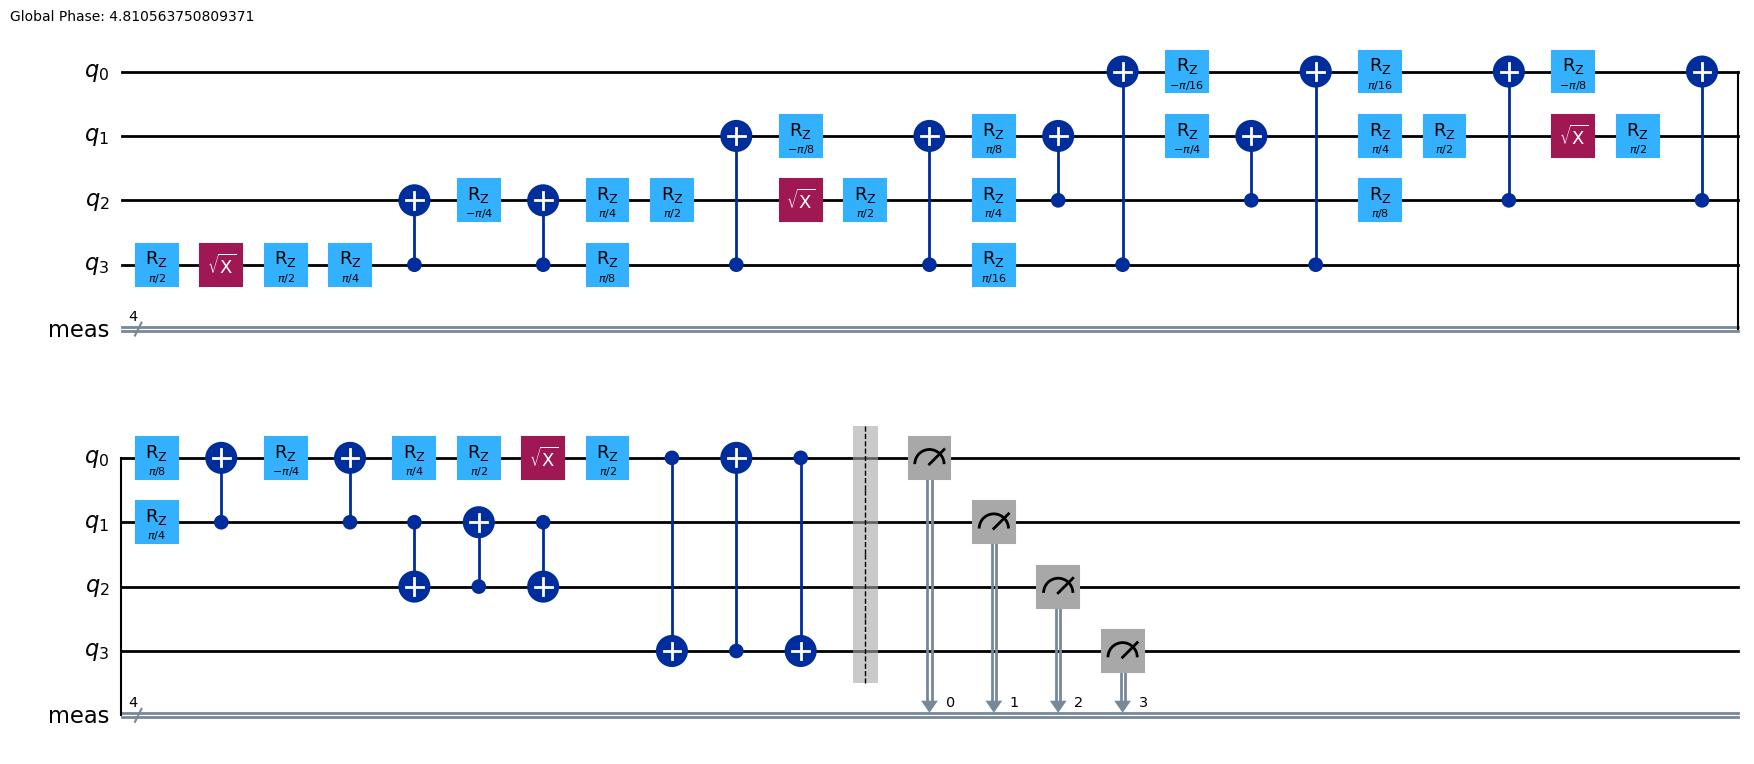

Best mapping layout: [(0, 0), (1, 1), (2, 2), (3, 3)]


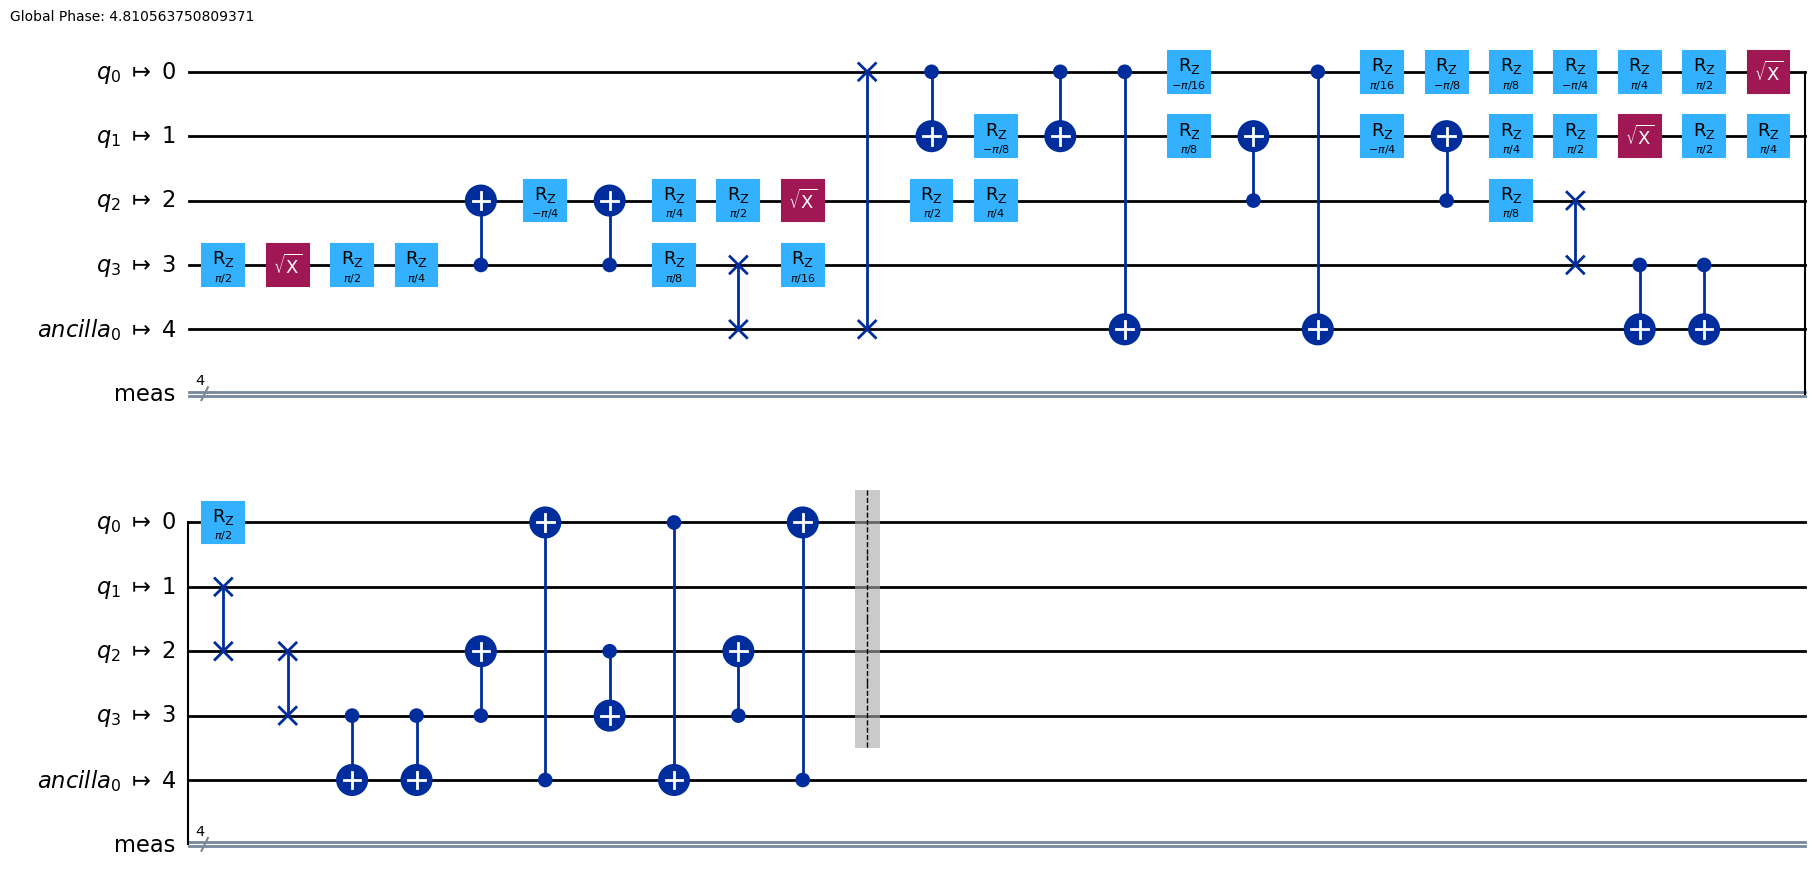

Initial qc size: 52 depth: 31
Routing isa size: 57 depth: 29


In [5]:
# fake_backend = FakeLondonV2()

num_qubits = 5
fake_backend = GenericBackendV2(num_qubits, coupling_map=CouplingMap.from_ring(num_qubits))
# qc = QuantumCircuit(num_qubits)
# qc.h(0)
# qc.cx(1, 2)

# qc.cx(1, 0)
# qc.cx(1, 2)
# qc.cx(2, 3)

# qc.cx(0, 2)
# qc.cx(1, 3)

# qc.measure_all()
# display(qc.draw("mpl"))

optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
qc = get_benchmark(
        benchmark_name="qft", level="nativegates", circuit_size=4, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
display(qc.draw('mpl'))
dag = circuit_to_dag(qc)

interaction_mapping = InteractionMapping(
    coupling_map=fake_backend.coupling_map, dag=dag
)
best_layout = interaction_mapping.get_best_qpi_layout()
print("Best mapping layout:", best_layout)

staged_pass = StagedPassManager()
# staged_pass.init = generate_preset_pass_manager(optimization_level=0, backend=fake_backend)
staged_pass.layout = PassManager(InteractionLayout(
    coupling_map=fake_backend.coupling_map, initial_map=best_layout
))
staged_pass.layout += generate_embed_passmanager(fake_backend.coupling_map)
staged_pass.routing = generate_routing_passmanager(
    DynamicLookaheadSwap(fake_backend.coupling_map), target=fake_backend.coupling_map
)
# sabre_pass = generate_preset_pass_manager(optimization_level=0, backend=fake_backend, layout_method='sabre', routing_method='sabre')

routing_isa = staged_pass.run(qc)
# routing_isa = staged_pass.run(qc).decompose()
display(routing_isa.draw("mpl"))
print(f"Initial qc size: {qc.size()} depth: {qc.depth()}")
print(f"Routing isa size: {routing_isa.size() + dag.num_clbits()} depth: {routing_isa.depth()}")

# routing_job = fake_backend.run(routing_isa)
# routing_counts = routing_job.result().get_counts()
# display(plot_histogram(routing_counts))

In [6]:
optimization_level = 0
compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))

In [7]:
benchmark_name = "ghz"
# level = "indep" # but cannot compare because need translation
level = "nativegates"
circuit_size = 5
qc_ghz = get_benchmark(
    benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
    compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
)
print(f"Circuit {benchmark_name}[{circuit_size}] -> size: {qc_ghz.size()} depth: {qc_ghz.depth()}")
# display(qc_ghz.draw("mpl"))

Circuit ghz[5] -> size: 12 depth: 8


Transpiled ghz[5] -> size: 12 depth: 8


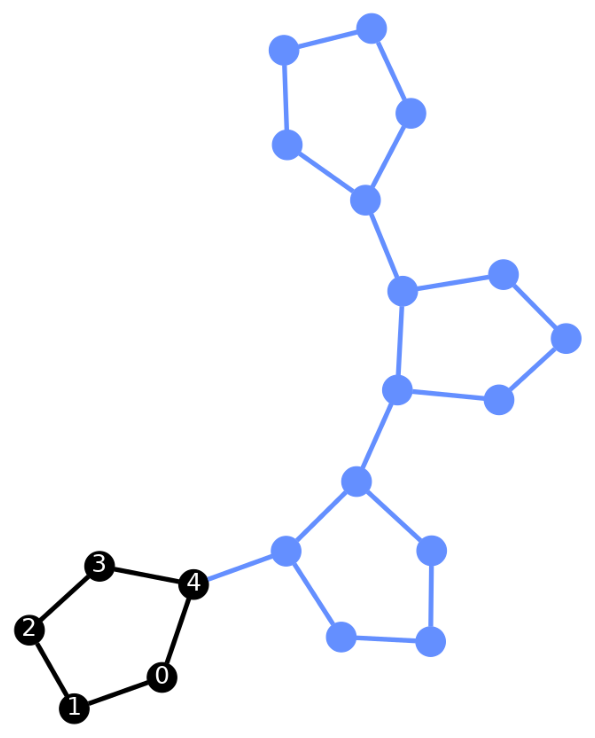

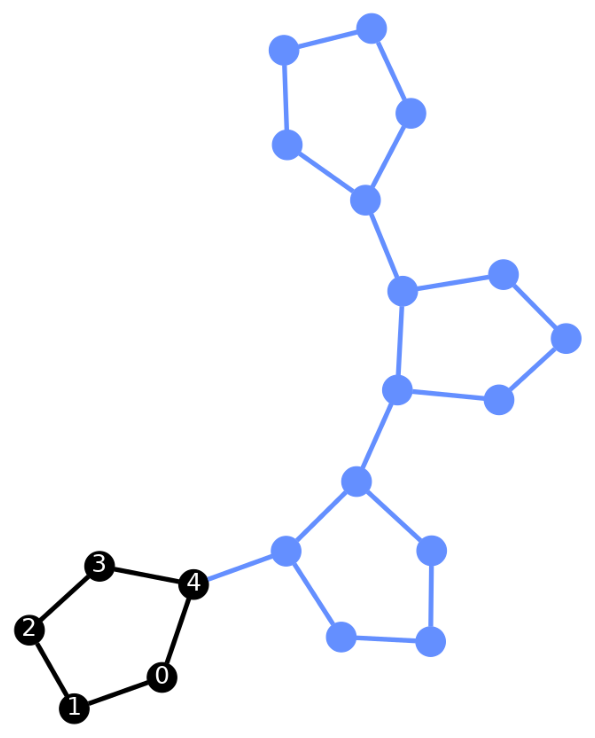

In [8]:
num_qubits = 5
num_group = 4
coupling_list_ring = build_coupling_list_ring(num_qubits, num_group)
coupling_map_ring = CouplingMap(couplinglist=coupling_list_ring)

backend_ring = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=coupling_map_ring)
pass_manager = generate_preset_pass_manager(optimization_level, backend=backend_ring)
qc_ghz_isa = pass_manager.run(qc_ghz)
print(f"Transpiled {benchmark_name}[{circuit_size}] -> size: {qc_ghz_isa.size()} depth: {qc_ghz_isa.depth()}")
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='physical'))
display(plot_circuit_layout(qc_ghz_isa, backend_ring, view='virtual'))

In [9]:
# Define a threshold for significant occurrence
# For example, here we use 10% of the maximum count as the threshold
def get_most_occurence(counts: dict, threshold_index: float = 0.7) -> list:
    threshold = threshold_index * max(counts.values())

    # Filter the keys based on the threshold
    significant_keys = [key for key, value in counts.items() if value > threshold]
    return significant_keys

In [10]:
job_ring = backend_ring.run(qc_ghz_isa)
counts_ring = job_ring.result().get_counts()
sig_ring_counts = get_most_occurence(counts_ring, 0.7)
sig_ring_counts.sort()

In [11]:
print(sig_ring_counts, "\n", len(sig_ring_counts))

['00000', '11111'] 
 2


In [12]:
# use dictionary to save the result
benchmark_name_list = [
    "ae", # list index out of range? because qreg use eval1, eval2, eval3
    "dj",
    # "grover-noancilla", # '[5] grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}
    # "grover-v-chain", # '[5] grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}
    "ghz",
    "graphstate",
    "portfolioqaoa",
    "portfoliovqe",
    "qaoa",
    "qft",
    "qftentangled",
    "qnn",
    "qpeexact",
    "qpeinexact",
    # "qwalk-noancilla", # '[5] qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}
    # "qwalk-v-chain", # '[5] qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}
    "random",
    "realamprandom",
    "su2random",
    "twolocalrandom",
    "vqe",
    "wstate",
    
    # non-scalable benchmarks
    
    # "shor", # benchmark_instance_name must be defined for this benchmark.
    # "pricingcall", # Benchmark pricingcall[5] -> size: 901 depth: 568 interval: 0.18169641494750977
    # "pricingput", # Benchmark pricingput[5] -> size: 931 depth: 568 interval: 0.1800365447998047
    # "groundstate", # benchmark_instance_name must be defined for this benchmark.
    # "routing",
    # "tsp",
]

In [13]:
circuit_size_list = [5, 10, 15]

def init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark):
    for circuit_size in circuit_size_list:
        if circuit_size not in dict_benchmark: # circuit size level
            dict_benchmark[circuit_size] = {}
            for benchmark_name in benchmark_name_list:
                if benchmark_name not in dict_benchmark[circuit_size]: # benchmark name level
                    dict_benchmark[circuit_size][benchmark_name] = {}
                    if 'init' not in dict_benchmark[circuit_size][benchmark_name]: # coupling map level
                        dict_benchmark[circuit_size][benchmark_name]['init'] = {}
    return dict_benchmark

In [14]:
# Initialize from EMPTY

# dict_benchmark = {} # level: circuit_size -> benchmark_name -> coupling_map, ex: ['init'], ['ring_5_4'], ['line_5_4'] -> ['size'], ['swap'], ['depth' (optional)], ['interval']

# line, full, ring_10_2, ring_5_4, grid_3_3_2, grid_3_2_3, t_horizontal_4, t_vertical_4

# provide around 20 num_qubits in total
# dict_benchmark = {}
# dict_benchmark = init_dict_benchmark(circuit_size_list, benchmark_name_list, dict_benchmark)
# print(dict_benchmark)

In [15]:
import json
def open_json_from_file(dict_benchmark):
    with open("result/benchmarking.json") as json_file:
        dict_benchmark = json.load(json_file)
    return dict_benchmark

In [16]:
# Initialize from JSON

dict_benchmark = {}
dict_benchmark = open_json_from_file(dict_benchmark)
print(dict_benchmark)

{'5': {'ae': {'init': {}}, 'dj': {'init': {'size': 40, 'depth': 12, 'interval': 0.0051822662353515625}, 't_vertical_5_4': {'sabre_size': 46, 'sabre_depth': 21, 'sabre_interval': 0.047060489654541016, 'sabre_swap': 6, 'lookahead_size': 41, 'lookahead_depth': 13, 'lookahead_interval': 0.03831768035888672, 'lookahead_swap': 3}, 'ring_5_4': {'sabre_size': 43, 'sabre_depth': 19, 'sabre_interval': 0.018605947494506836, 'sabre_swap': 3, 'lookahead_size': 41, 'lookahead_depth': 13, 'lookahead_interval': 0.010549068450927734, 'lookahead_swap': 3}, 'ring_10_2': {'sabre_size': 49, 'sabre_depth': 24, 'sabre_interval': 0.014000892639160156, 'sabre_swap': 9, 'lookahead_size': 41, 'lookahead_depth': 13, 'lookahead_interval': 0.01285243034362793, 'lookahead_swap': 3}}, 'ghz': {'init': {'size': 12, 'depth': 8, 'interval': 0.012210369110107422}, 't_vertical_5_4': {'sabre_size': 15, 'sabre_depth': 8, 'sabre_interval': 0.024756669998168945, 'sabre_swap': 3, 'lookahead_size': 12, 'lookahead_depth': 8, 'loo

In [17]:
import json
def save_dict_to_file(dict_benchmark):
    with(open("result/benchmarking.json", "w") as outfile):
        json.dump(dict_benchmark, outfile)

In [18]:
def start_initial_benchmark(benchmark_name: str, circuit_size: int, dict_benchmark: dict):
    level = "nativegates"
    optimization_level = 0
    compiler_settings = CompilerSettings(qiskit=QiskitSettings(optimization_level))
    with Timer() as t:
        qc = get_benchmark(
        benchmark_name=benchmark_name, level=level, circuit_size=circuit_size, 
        compiler="qiskit", compiler_settings=compiler_settings, provider_name="ibm"
        )
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['size'] = qc.size()
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['depth'] = qc.depth()
    dict_benchmark[str(circuit_size)][benchmark_name]['init']['interval'] = t.interval

    dag = circuit_to_dag(qc)
    return qc, dag

# if want to change interval in ms = t.interval*10**3

In [19]:
import math

def build_generic_backend(
    layout_name: str, num_qubits: int, num_group: int # num_rows and num_cols only used in grid
) ->  GenericBackendV2:
    if layout_name == "full":
        couplinglist = build_coupling_list_full(num_qubits)
    elif layout_name == "line":
        couplinglist = build_coupling_list_line(num_qubits, num_group)
    elif layout_name == "ring":
        couplinglist = build_coupling_list_ring(num_qubits, num_group)
    elif layout_name == "grid":
        couplinglist = build_coupling_list_grid(
            num_rows=math.ceil(math.sqrt(num_qubits)),
            num_columns=math.ceil(math.sqrt(num_qubits)),
            num_group=num_group,
        )
    elif layout_name == "t_horizontal":
        couplinglist = build_coupling_list_t_horizontal(num_group)
    elif layout_name == "t_vertical":
        couplinglist = build_coupling_list_t_vertical(num_group)
    else:
        raise Exception(f"Layout name: {layout_name} is not supported yet.")

    gen_backend = GenericBackendV2(num_qubits=num_qubits * num_group, coupling_map=couplinglist) # can directly add coupling list without casting to CouplingMap
    return gen_backend

In [20]:
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator


def build_pass_manager(
    routing_option: str, backend: Backend, best_layout=None
) -> PassManager:
    if routing_option == "lookahead":
        if best_layout is None:
            raise Exception(
                f"Provide initial layout for Interaction Layout and Lookahead Swap."
            )
        pass_manager = StagedPassManager()
        pass_manager.layout = PassManager(
            InteractionLayout(
                coupling_map=backend.coupling_map, initial_map=best_layout
            )
        )
        pass_manager.layout += generate_embed_passmanager(backend.coupling_map)
        pass_manager.routing = generate_routing_passmanager(
            DynamicLookaheadSwap(backend.coupling_map),
            target=backend.coupling_map,
        )
        # TODO: routing here adds SWAP gate, need to multiply by 3

    elif routing_option == "sabre":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="sabre",
            routing_method="sabre",
        )
    elif routing_option == "basic":
        pass_manager = generate_preset_pass_manager(
            optimization_level=0,
            backend=backend,
            layout_method="trivial",
            routing_method="basic",
        )
    else:
        raise Exception(f"Swap technique {routing_option} is not available yet.")
    return pass_manager

In [21]:
def update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark):
    with Timer() as t:
        backend = build_generic_backend(layout_name, num_qubits, num_group)
        mapping = InteractionMapping(backend.coupling_map, dag)
        print(f"Best layout: {mapping.get_best_qpi_layout()}")
        pm = build_pass_manager(routing_option, backend, mapping.get_best_qpi_layout())
        isa = pm.run(qc)
        display(plot_circuit_layout(isa, backend))
    
    if f'{layout_name}_{num_qubits}_{num_group}' not in dict_benchmark[str(circuit_size)][benchmark_name]:
        dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'] = {}
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_size'] = isa.size()
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_depth'] = isa.depth()
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_interval'] = t.interval

    if routing_option == 'lookahead':
        additional_swap = (isa.size() + dag.num_clbits() - qc.size()) * 3 # TODO: issue with measure mapping, therefore add swap calculation here
    else:
        additional_swap = (isa.size() - qc.size())
    dict_benchmark[str(circuit_size)][benchmark_name][f'{layout_name}_{num_qubits}_{num_group}'][f'{routing_option}_swap'] = additional_swap

In [22]:
benchmark_name_list = [
    # "ae", # list index out of range? because qreg use eval1, eval2, eval3
    "dj",
    # "grover-noancilla", # '[5] grover-noancilla': {'size': 720, 'depth': 453, 'interval': 0.13467860221862793}
    # "grover-v-chain", # '[5] grover-v-chain': {'size': 750, 'depth': 464, 'interval': 0.11993575096130371}
    "ghz",
    "graphstate", # [15] t_vertical
    "portfolioqaoa",
    "portfoliovqe",
    "qaoa", # TODO: too long on solver(?)
    "qft", # [15] all failed except full & grid
    "qftentangled", # DONE easy
    "qnn", # [10] ring_10_2, ring_5_4, t_vertical_5_4 [15] all failed except full & line
    "qpeexact", # qreg use psi Qubit(QuantumRegister(9, 'q'), 8), Qubit(QuantumRegister(1, 'psi'), 0)
    "qpeinexact", # qreg use psi
    # "qwalk-noancilla", # '[5] qwalk-noancilla': {'size': 1310, 'depth': 915, 'interval': 0.07286214828491211}
    # "qwalk-v-chain", # '[5] qwalk-v-chain': {'size': 856, 'depth': 583, 'interval': 0.022635459899902344}
    "random", # [15] all failed except full
    "realamprandom", # [15] all except full & line
    "su2random", # [15] grid_9_2, ring failed
    "twolocalrandom", # [10] t_vertical, ring_10_2 [15] ring_10_2, ring_5_4, grid, t failed with stopper at > 250
    "vqe", # [10, 15] ALL WORKS
    "wstate", # [10, 15] ALL WORKS
]

# Probably it stops because at the very end, cannot go back?

Best layout: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]


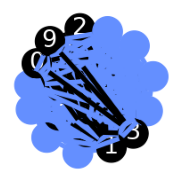

Best layout: [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9)]


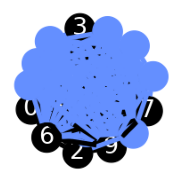

Best layout: [(1, 1), (2, 0), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (0, 8), (9, 9)]


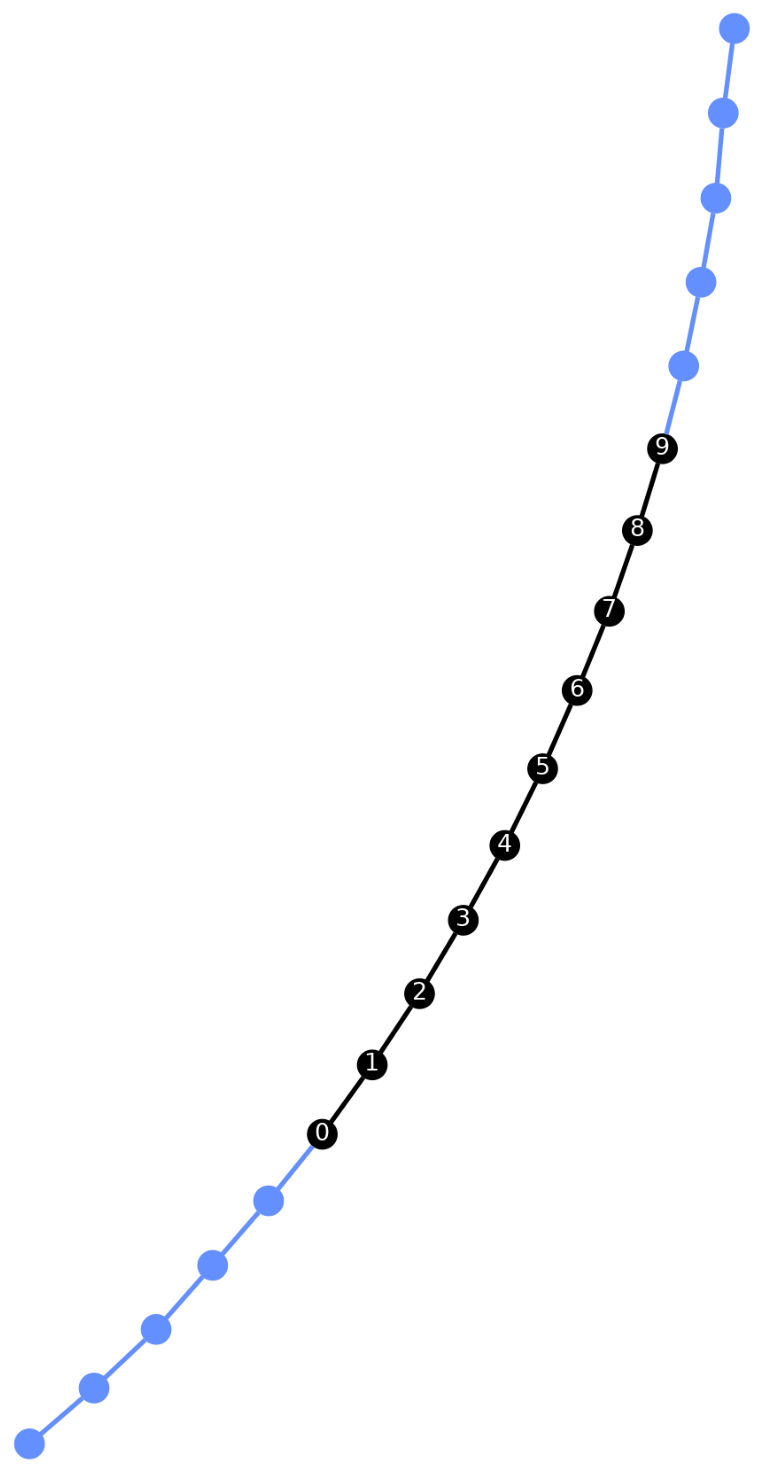

Best layout: [(1, 1), (2, 0), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (0, 8), (9, 9)]


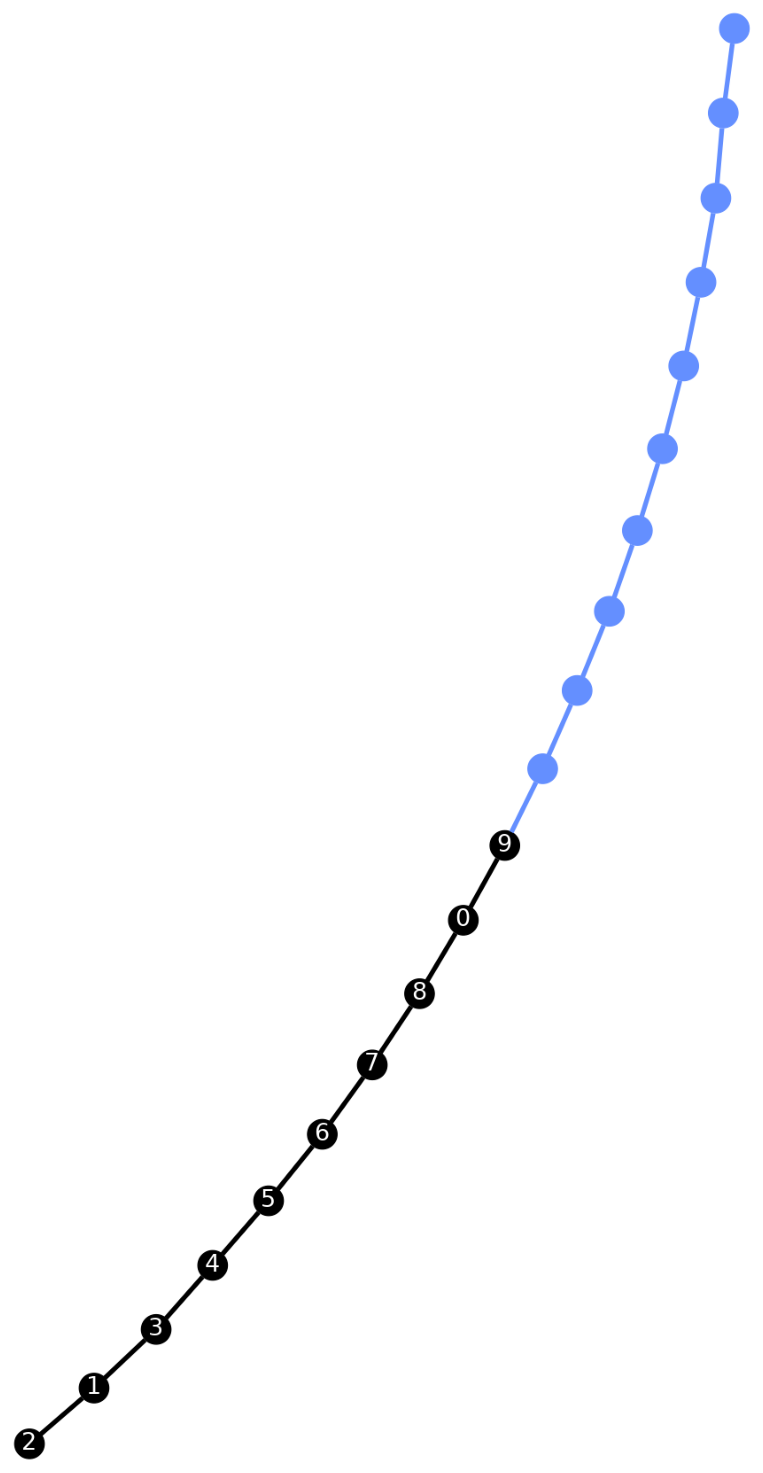

Best layout: [(1, 9), (2, 10), (3, 8), (4, 0), (5, 19), (6, 11), (7, 7), (8, 1), (0, 18), (9, 12)]


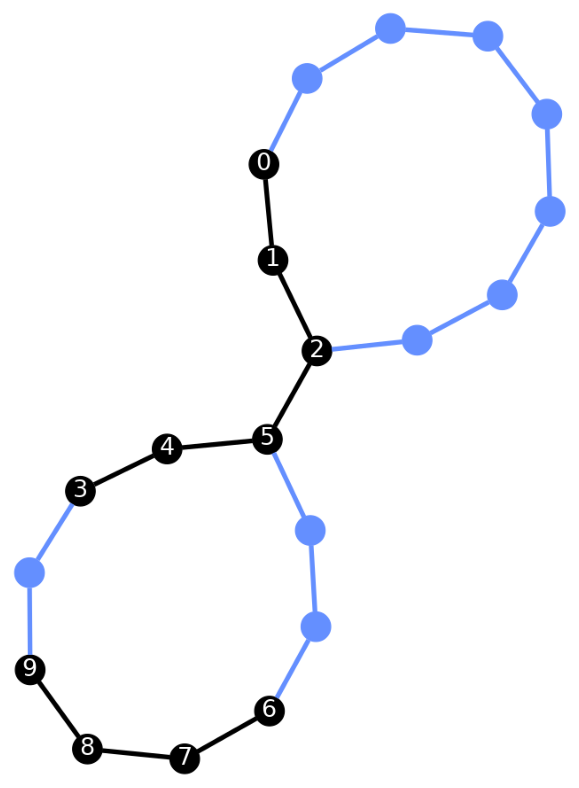

Best layout: [(1, 9), (2, 10), (3, 8), (4, 0), (5, 19), (6, 11), (7, 7), (8, 1), (0, 18), (9, 12)]


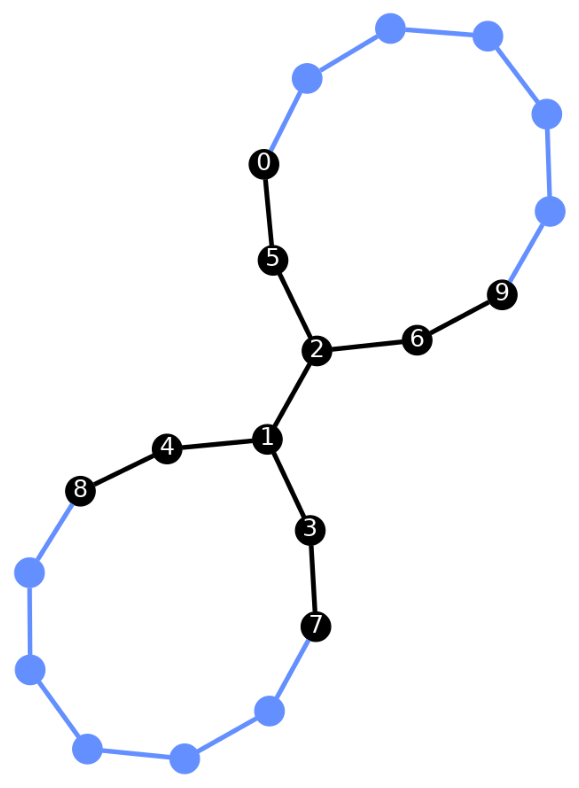

Best layout: [(1, 4), (2, 5), (3, 3), (4, 0), (5, 9), (6, 6), (7, 2), (8, 1), (0, 10), (9, 8)]


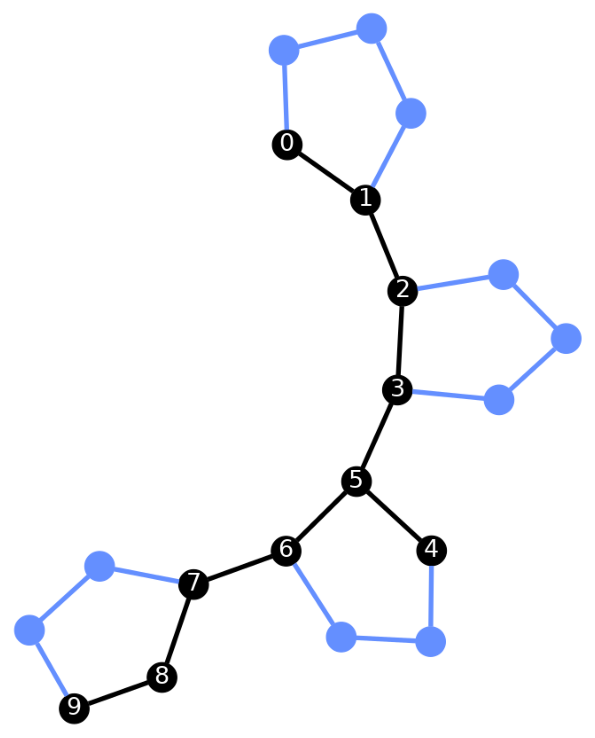

Best layout: [(1, 4), (2, 5), (3, 3), (4, 0), (5, 9), (6, 6), (7, 2), (8, 1), (0, 10), (9, 8)]


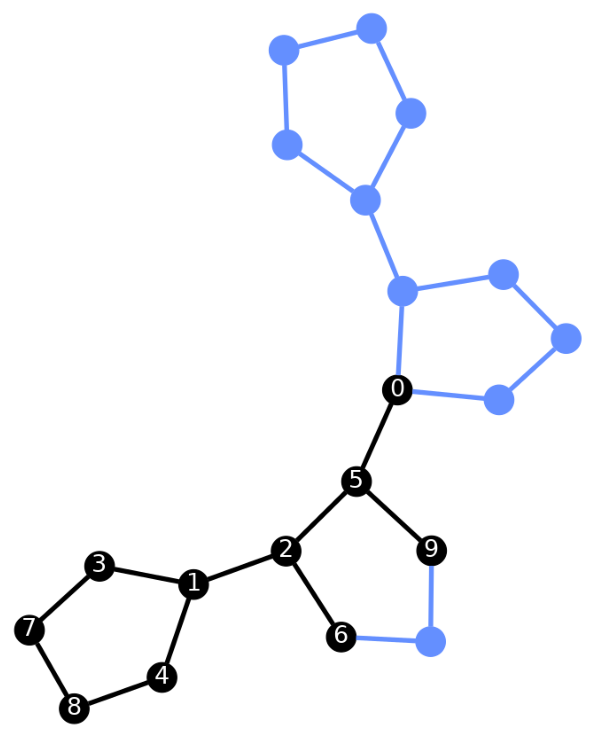

Best layout: [(1, 4), (2, 3), (3, 5), (4, 7), (5, 1), (6, 6), (7, 0), (8, 8), (0, 2), (9, 9)]


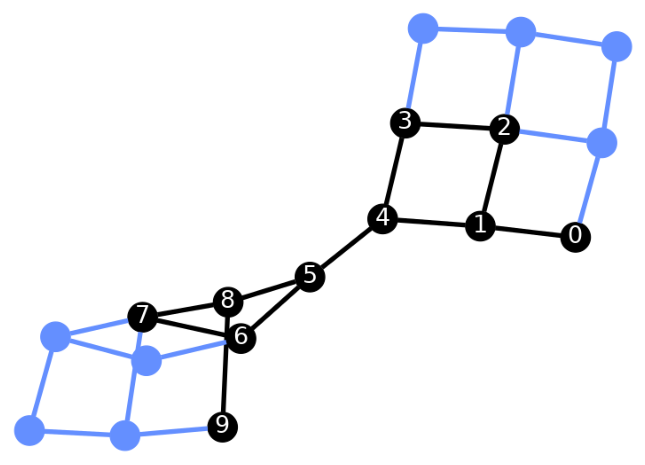

Best layout: [(1, 4), (2, 3), (3, 5), (4, 7), (5, 1), (6, 6), (7, 0), (8, 8), (0, 2), (9, 9)]


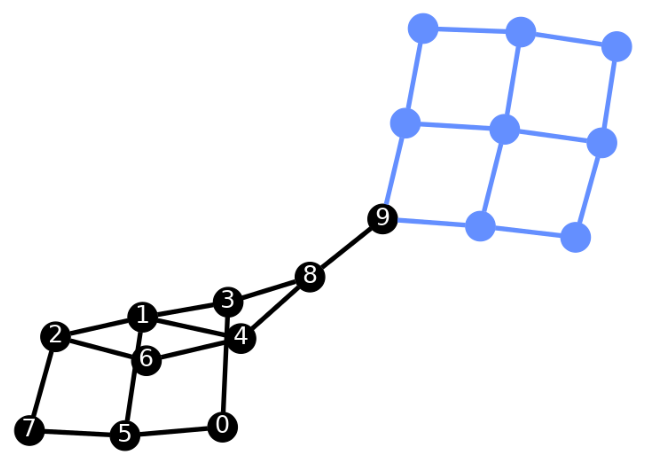

Best layout: [(1, 1), (2, 0), (3, 3), (4, 2), (5, 4), (6, 5), (7, 6), (8, 8), (0, 7), (9, 9)]


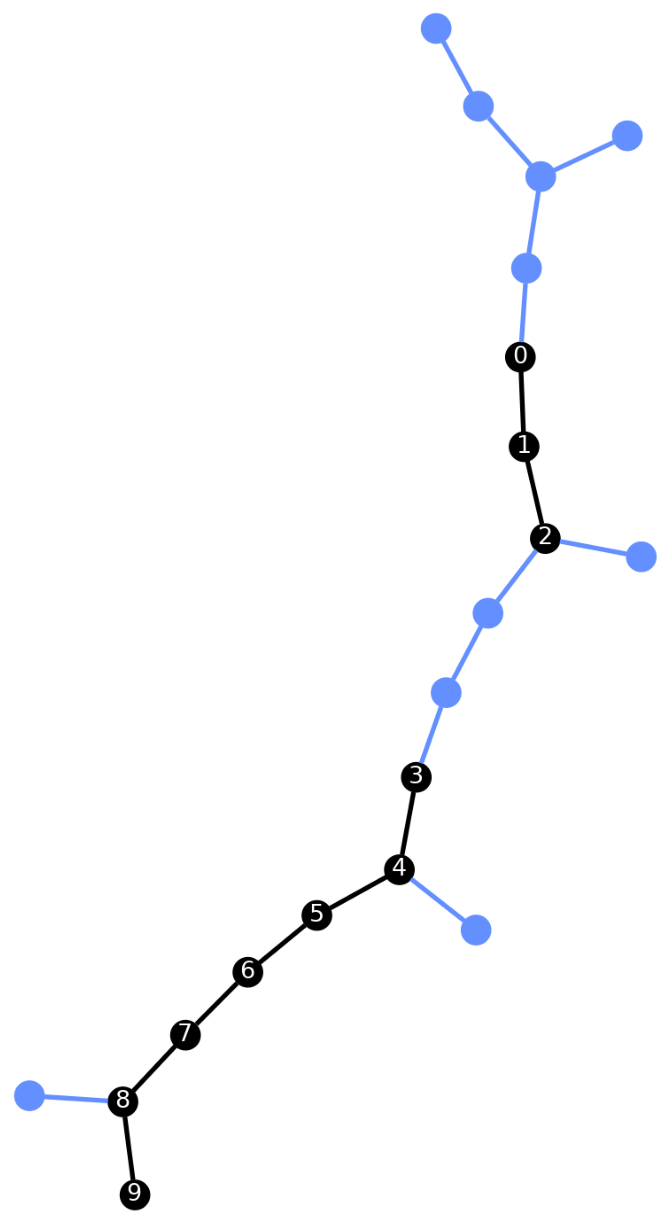

Best layout: [(1, 1), (2, 0), (3, 3), (4, 2), (5, 4), (6, 5), (7, 6), (8, 8), (0, 7), (9, 9)]


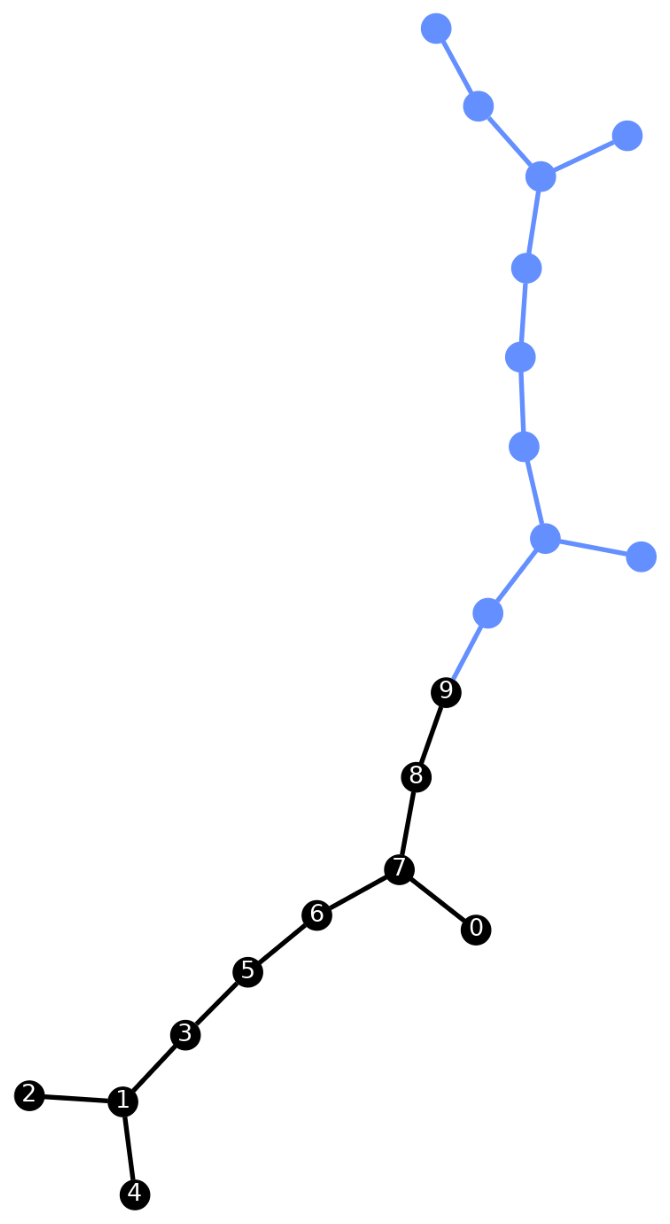

Best layout: [(1, 1), (2, 0), (3, 3), (4, 2), (5, 4), (6, 5), (7, 6), (8, 8), (0, 7), (9, 9)]


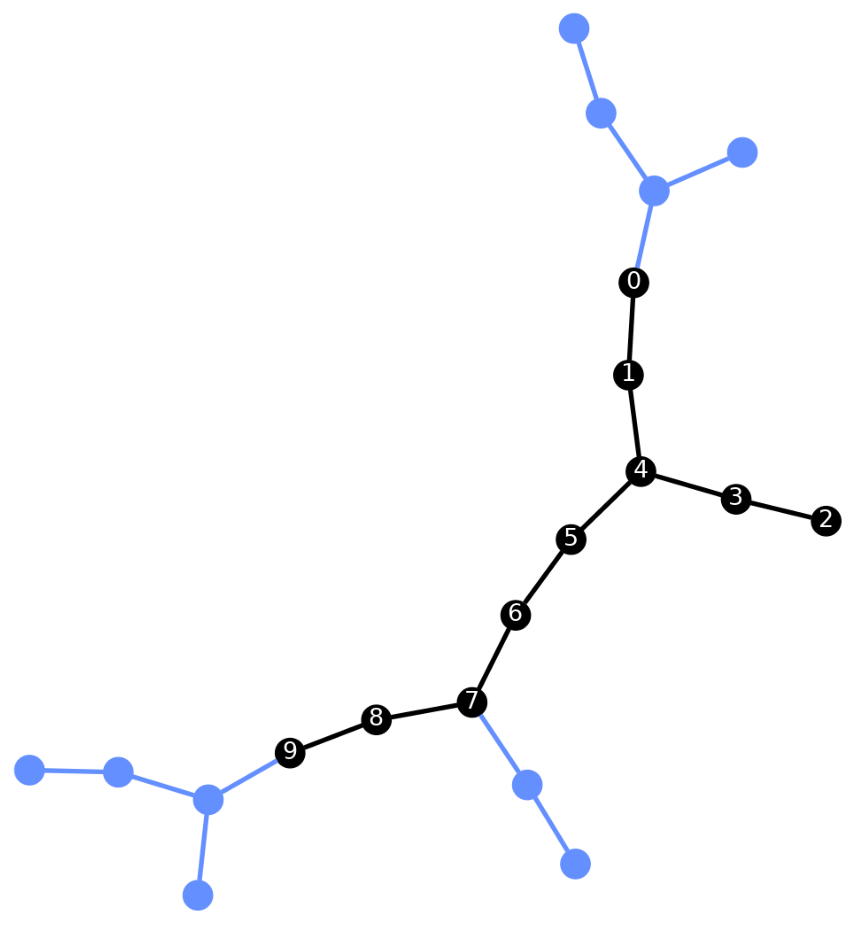

Best layout: [(1, 1), (2, 0), (3, 3), (4, 2), (5, 4), (6, 5), (7, 6), (8, 8), (0, 7), (9, 9)]


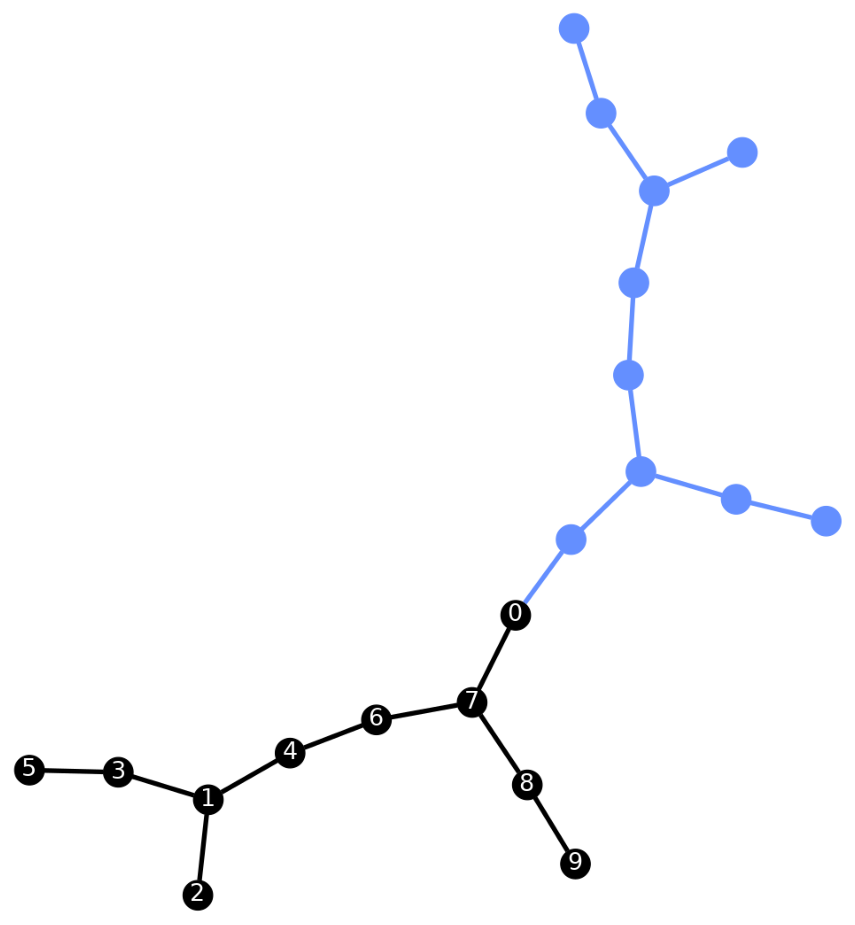

In [85]:
circuit_size = 10
benchmark_name = "wstate"
# for circuit_size in circuit_size_list:
# for benchmark_name in benchmark_name_list:
qc, dag = start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
routing_options = ['sabre', 'lookahead']

distributed_options = [
    ['full', 20, 1],
    ['line', 5, 4],
    ['ring', 10, 2],
    ['ring', 5, 4],
    ['grid', 9, 2],
    ['t_horizontal', 5, 4],
    ['t_vertical', 5, 4]
]

for layout_name, num_qubits, num_group in distributed_options:
    for routing_option in routing_options:
        update_dict_size_depth(qc, dag, layout_name, num_qubits, num_group, routing_option, dict_benchmark)

# Circuit size: 5 with time: 6.1507463455200195 (6.1s)
# DJ [5] takes 21m 2.8s long, not sure how long anymore

In [ ]:
save_dict_to_file(dict_benchmark)

Initialization QC:
- Circuit size: 10 with time: 28.9819118976593 (28.9s)
- Circuit size: 15 with time: 718.7938868999481 (11m 58.7s)

Init without non-scalable:
- Circuit [5]: 0.006738901138305664
- Circuit [10]: 0.009879827499389648
- Circuit [15]: 0.03544354438781738
Timeout for circuit with num_qubits = 20

In [ ]:
# for circuit_size in circuit_size_list:
#     for benchmark_name in benchmark_name_list:
#         with Timer() as t:
#             start_initial_benchmark(benchmark_name=benchmark_name, circuit_size=circuit_size, dict_benchmark=dict_benchmark)
#     print(f"Circuit [{circuit_size}]: {t.interval}")

# print(dict_benchmark)

# Circuit [5]: 0.006738901138305664
# Circuit [10]: 0.009879827499389648
# Circuit [15]: 0.03544354438781738
# Timeout for circuit with num_qubits = 20

In [ ]:
print(dict_benchmark)